In [3]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model
import pickle
import tarfile
from urllib.request import urlretrieve
import os
import nltk
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np
from scipy.sparse import save_npz, load_npz
from tensorflow.python.keras import backend as K
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils import plot_model
import pandas as pd
%matplotlib inline

In [4]:
with open('nyt_markets_df_bert_sim.pickle', 'rb') as dff:
    nyt_markets_df_bertsim = pickle.load(dff)

In [5]:
docs = nyt_markets_df_bertsim['article_clean_2']

In [6]:
docs

0        good wednesday want email sign hereboth inside...
1        dozens people gathered manhattan rooftop nibbl...
2        london  royal dutch shell became latest big en...
3        weeks top stories presidential candidates made...
5        burg migheizil egypt  raggedy fishing village ...
                               ...                        
13921    want get briefing email heres signupgood morni...
13922    college student early s charles trafton worked...
13923    london  outlining first tentative details inte...
13924    good wednesday heres were watching facebook re...
13925    seoul south korea  president trump struggles d...
Name: article_clean_2, Length: 13496, dtype: object

In [7]:
v_size = 3000
tokenizer = Tokenizer(num_words=v_size, oov_token='UNK')
tokenizer.fit_on_texts(docs)

In [8]:
def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    sequences = tokenizer.texts_to_sequences(text)
    
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    for sequence in sequences:
        for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
            context_window = sequence[i-window_size: i+window_size+1]
            distances = np.abs(np.arange(-window_size, window_size+1))
            distances[window_size] = 1.0
            nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
            nom[window_size] = 0.0

            if use_weighting:
                cooc_mat[wi, context_window] += nom/distances    # Update element
            else:
                cooc_mat[wi, context_window] += nom
    
    return cooc_mat

In [14]:
cooc_mat = generate_cooc_matrix(docs[0:7500], tokenizer, 4, v_size, True) #around half of data

In [15]:
cooc_mat

<3000x3000 sparse matrix of type '<class 'numpy.float32'>'
	with 4197799 stored elements in LInked List format>

([<matplotlib.axis.XTick at 0x1a6397c8d0>,
 <a list of 25 Text xticklabel objects>)

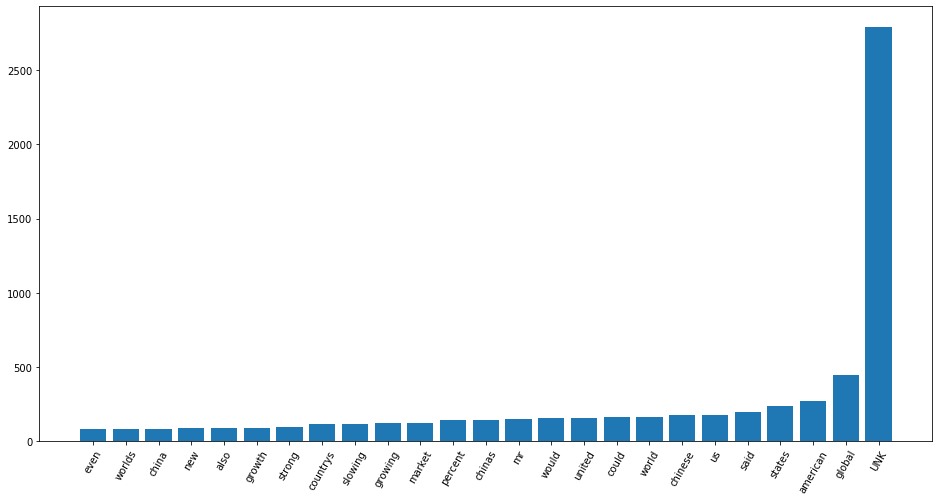

In [16]:
word = 'economy'
assert word in tokenizer.word_index, 'Word {} is not in the tokenizer'.format(word)
assert tokenizer.word_index[word] <= v_size, 'The word {} is an out of vocabuary word. Please try something else'.format(word)

rev_word_index = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))

cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
max_ind = np.argsort(cooc_vec)[-25:]
#print(max_ind)
plt.figure(figsize=(16,8))
plt.bar(np.arange(0, 25), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 25), labels=[rev_word_index[i] for i in max_ind], rotation=60)

In [17]:
pickle.dump(cooc_mat, open('nyt_markets_glove_cooc_mat.pickle', 'wb'))

In [18]:
with open('nyt_markets_glove_cooc_mat.pickle', 'rb') as cooc:
    cooc_mat = pickle.load(cooc)

In [19]:
cooc_mat

<3000x3000 sparse matrix of type '<class 'numpy.float32'>'
	with 4197799 stored elements in LInked List format>

In [20]:
def create_glove_model(v_size):
    
    w_i = Input(shape=(1,))
    w_j = Input(shape=(1,))

    emb_i = Flatten()(Embedding(v_size, 96, input_length=1)(w_i))
    emb_j = Flatten()(Embedding(v_size, 96, input_length=1)(w_j))

    ij_dot = Dot(axes=-1)([emb_i,emb_j])
    
    b_i = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_i)
    )
    b_j = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_j)
    )

    pred = Add()([ij_dot, b_i, b_j])

    def glove_loss(y_true, y_pred):
        return K.sum(
            K.pow((y_true-1)/100.0, 0.75)*K.square(y_pred - K.log(y_true))
        )

    model = Model(inputs=[w_i, w_j],outputs=pred)
    model.compile(loss=glove_loss, optimizer =Adam(lr=0.0001))
    return model

In [21]:
K.clear_session()
model = create_glove_model(v_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 96)        288000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 96)        288000      input_2[0][0]                    
______________________________________________________________________________________________

In [33]:
import scipy
cooc_mat_array = cooc_mat.toarray()
batch_size =128
copy_docs = list(docs[0:100])
index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
""" Each epoch """
for ep in range(2):
    
    #valid_words = get_valid_words(docs, 20, tokenizer)
    
    random.shuffle(copy_docs)
    losses = []
    """ Each document (i.e. movie plot) """
    for doc in copy_docs:
        
        seq = tokenizer.texts_to_sequences([doc])[0]

        """ Getting skip-gram data """
        # Negative samples are automatically sampled by tf loss function
        wpairs, labels = skipgrams(
            sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
        )
        
        if len(wpairs)==0:
            continue

        sg_in, sg_out = zip(*wpairs)
        sg_in, sg_out = np.array(sg_in).reshape(-1,1), np.array(sg_out).reshape(-1,1)
        x_ij = np.array(cooc_mat_array[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) + 1
        #x_ij = np.array(cooc_mat[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) 
        
        assert np.all(np.array(labels)==1)
        assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
        """ For each batch in the dataset """
        model.fit([sg_in, sg_out], x_ij, batch_size = batch_size, epochs=1, verbose=0)
        l = model.evaluate([sg_in, sg_out], x_ij, batch_size=batch_size, verbose=0)
        losses.append(l)
    print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))

Loss in epoch 0: 6865.473522808945
Loss in epoch 1: 2104.8612342061847


In [39]:

def save_embeddings(model,save_dir, tok, v_size):
    """ Saving data to disk """
    
    # We need to add the 0th index to word list manually
    word_list = ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,v_size)]
    emb_w_df = None
    for layer in model.layers:
        if 'embedding' == layer.name or 'embedding_1' == layer.name:
            if emb_w_df is None:
                emb_w_df = pd.DataFrame(layer.get_weights()[0])
            else:
                emb_w_df += layer.get_weights()[0]
    
    emb_w_df.insert(0, "word", word_list)
            
    emb_w_df.to_csv(
        os.path.join(save_dir, 'embeddings_w.csv'), index=False, header=None
    )
    
save_embeddings(model, '/Users/matthewvitha/Downloads/glovemodel', tokenizer, v_size)
#model.save('glove1_model.h5')

In [45]:
def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(100)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words
        

valid_words = get_valid_words(docs, 100, tokenizer)
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(filename, index_col=False, header=None)
    embed_df = embed_df.set_index(0)
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_cosine_sim(emb, valid_words, top_k):
    norm = np.sqrt(np.sum(emb**2,axis=1,keepdims=True))
    norm_emb = emb/norm
    in_emb = norm_emb[valid_words,:]
    similarity = np.dot(in_emb, np.transpose(norm_emb))
    sorted_ind = np.argsort(-similarity, axis=1)[:,1:top_k+1]
    return sorted_ind, valid_words

embed_mat, words = load_embeddings(os.path.join('/Users/matthewvitha/Downloads/glovemodel','embeddings_w.csv'))
best_ids, wids = get_cosine_sim(embed_mat, valid_words, 5)
pd.Series(words).to_csv(os.path.join('/Users/matthewvitha/Downloads/glovemodel','index2word.csv'))
for w, bi in zip(wids, best_ids):
    print("{}: {}".format(words[w], ', '.join(words[bii] for bii in bi)))

Loading the word embeddings from the disk
Embedding shape: (3000, 96)
history: million, UNK, high, see, like
trump: UNK, mr, new, company, york
UNK: new, mr, trump, time, york
trading: UNK, even, said, mr, ms
returning: taken, walked, rising, size, australian
UNK: new, mr, trump, time, york
UNK: new, mr, trump, time, york
holdings: seen, need, change, local, onto
ryan: inside, today, state, get, director
UNK: new, mr, trump, time, york
UNK: new, mr, trump, time, york
saying: UNK, world, like, prices, also
positions: needed, beijing, center, didnt, bill
remain: UNK, briefing, make, see, financial
cut: UNK, make, new, back, end
UNK: new, mr, trump, time, york
protections: fill, st, tried, restrictions, billionaire
UNK: new, mr, trump, time, york
sources: reach, tech, turned, think, asian
UNK: new, mr, trump, time, york
countrys: business, percent, UNK, known, however
minutes: UNK, month, also, remains, one
response: stocks, them, take, days, fuel
UNK: new, mr, trump, time, york
UNK: new,

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
